# CS4168 Data Mining

## Lab 5: Regression & Dimensionality

**David Walsh 20276885**

*To Do:*
* Repeat the experiment in Lab5 - Regression and Dimensionality
Reduction.ipynb with insurance.csv and draw conclusions from the results you
observe in a markdown cell. Add a third regression algorithm of your choice.
Describe how it compares to Random Forest and Linear regression in a markdown
cell (max 250 words in a markdown cell).
* Add two dimensionality-reduction methods which are not used in CS5062 - Lab5 -
Regression and Dimensionality Reduction.ipynb to the training pipelinesfor insurance.csv. Aim at dimensionality reduction techniques that are sufficiently
different from the ones used in the example notebook. Draw conclusions from the
results you observe in a markdown cell (max 250 words in a markdown cell).

In [ ]:
# Standard libraries
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# Enable inline plotting for matplotlib
%matplotlib inline

# Preprocessing and model selection utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin

# Dimensionality reduction
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import FeatureAgglomeration
from sklearn.feature_selection import RFE

# Regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Model evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuration settings (optional, if needed for displaying sklearn diagrams)
from sklearn import set_config
# set_config(display='diagram')  # Uncomment if you want to display diagrams

## 1. EDA - Exploratory Data Analysis

In [ ]:
df = pd.read_csv("./insurance.csv")

In [ ]:
df.head(6)

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075
5,18,male,31.680,2,yes,southeast,34303.16720


In [ ]:
df.tail(6)

,age,gender,bmi,children,smoker,region,insurance_cost
1332,64,female,35.970,0,no,southeast,14313.84630
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


In [ ]:
df.shape

(1338, 7)

Categorical columns:
* `gender`
* `smoker`
* `region`

In [ ]:
df['gender'].value_counts()

male      676
female    662
Name: gender, dtype: int64

In [ ]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [ ]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [ ]:
df.isna().sum() # Checking for missing values and outliers

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

* There are no obvious missing values.
* Will now examine the basic statistics of the numerical attributes.

In [ ]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


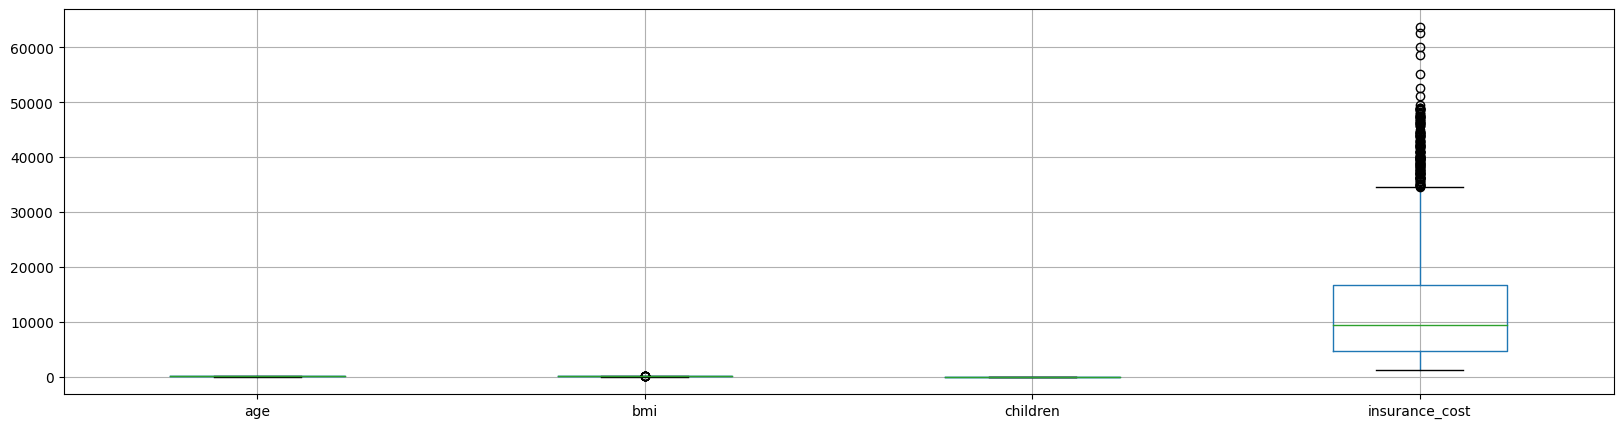

In [ ]:
# Checking for outliers in the numerical columns
df.boxplot(figsize = (20, 5))
plt.show()

There are some outliers in the `length` and `bmi` columns. We will apply RobustScaler to them and StandardScaler to `age` and `children`. Let's also examine the histograms of all attribtes.

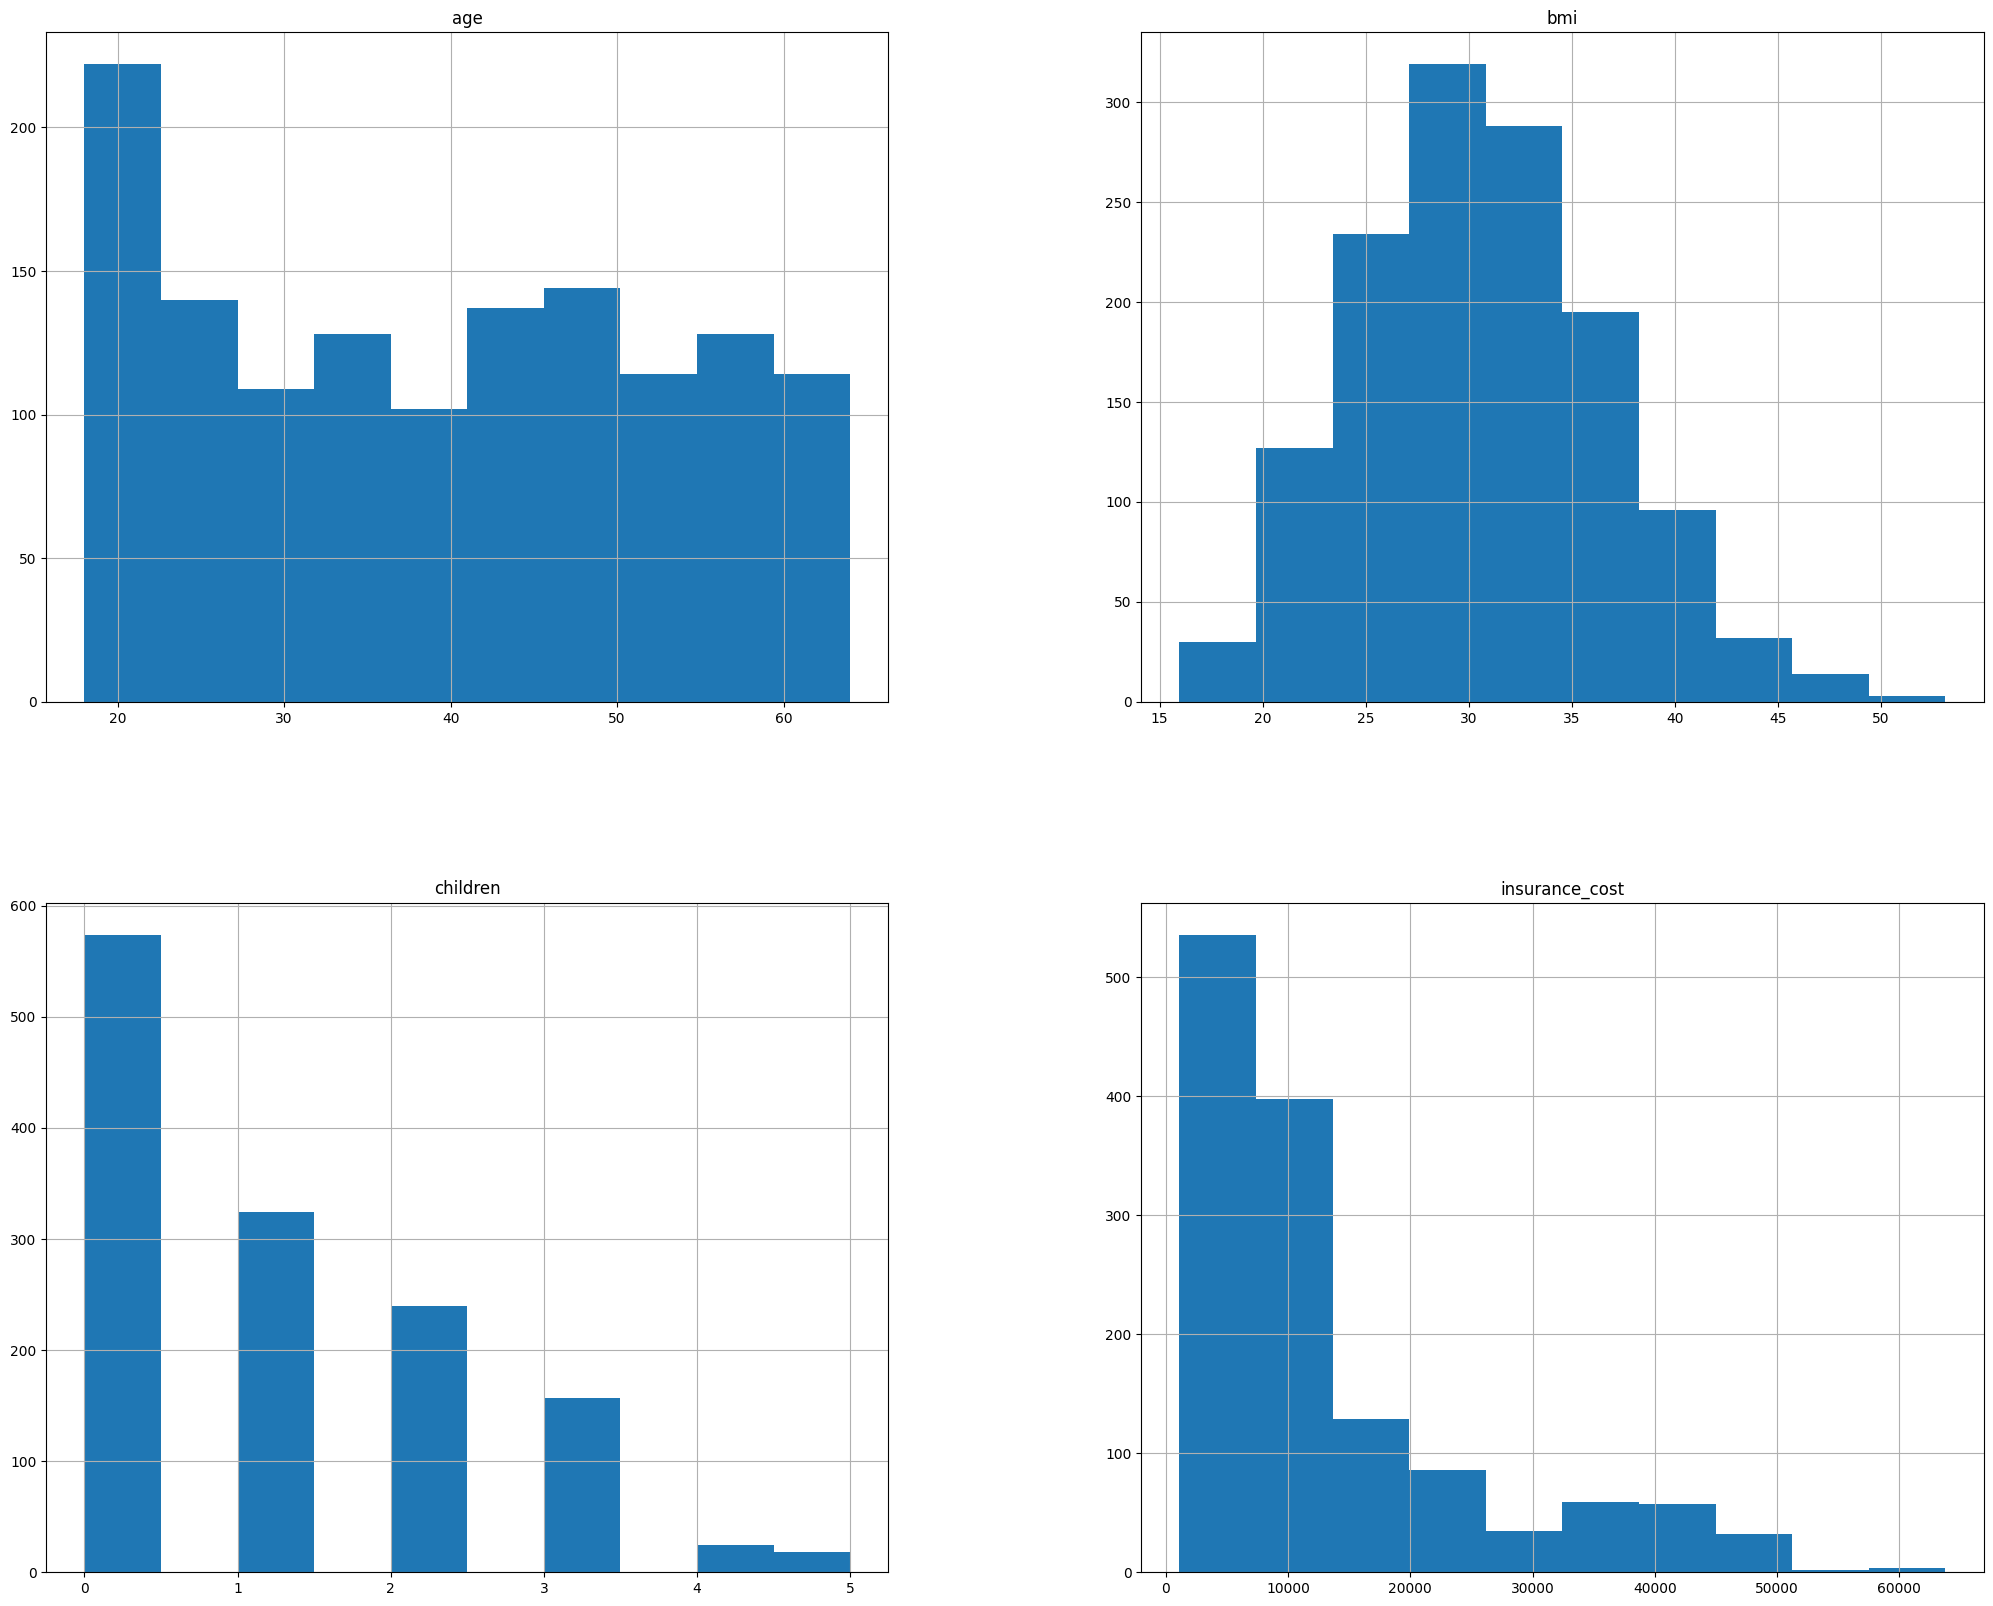

In [ ]:
df.hist(bins = 10, figsize = (25, 20));

The histograms above show a relatively close-to-normal distribution for all four numerical predictors. Thus, we won't apply a logarithmic or cubic root transformation to them.

Next, let's examine the `bmi` column which is the target of the regression model we are about to train

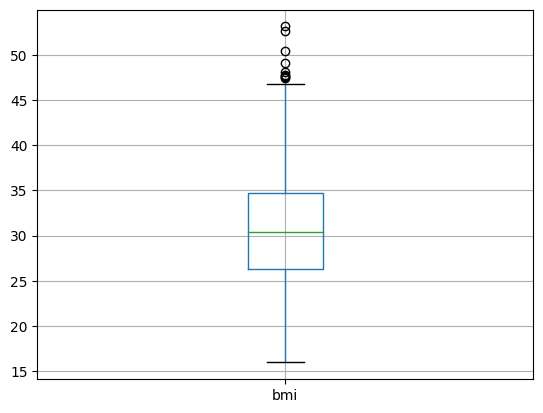

In [ ]:
df.boxplot(column = ['bmi'])
plt.show()

The examples shown as outliers are in fact acceptable. Someone's bmi can be over 50.

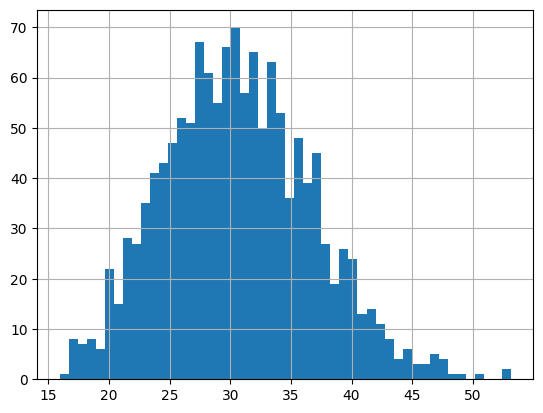

In [ ]:
df['bmi'].hist(bins = 50)
plt.show()

Depending on the regression model we train, we may want to apply a logarithmic transformation the target variable. i.e. `bmi`.

## 2. Data Preparation

In [ ]:
# Splitting the columns into a target y and predictors X
y = df['bmi']
X = df.drop('bmi', axis = 1)

Next, similar to the classification exercise, we will build a data preprocessing pipeline in which we will apply one-hot encoding to the `Species` column, as well as scalers to the numerical predictors as we discussed above. The transformation of the target will be done later when we build the final pipeline.

In [ ]:
preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("no_outliers", StandardScaler(), ['age', 'children']),
        ("categorical", OneHotEncoder(drop = 'first', sparse_output = False), ['gender', 'smoker', 'region'])
    ],
    remainder = RobustScaler() # i.e. ['bmi', 'insurance_cost' ]
).set_output(transform = "pandas")

# The output of preprocess_pipeline is set to "pandas",
# so we can view the output of the pipeline as a dataframe with
# the names of the columns. We do this just as a test in the next few cells.
# Otherwise, the output would be a numpy array.

In [ ]:
X_transformed = preprocess_pipeline.fit_transform(X);

In [ ]:
X_transformed.head(6)

,no_outliers__age,no_outliers__children,categorical__gender_male,categorical__smoker_yes,categorical__region_northwest,categorical__region_southeast,categorical__region_southwest,remainder__insurance_cost
0,-1.509965,-0.078767,1.0,0.0,0.0,1.0,0.0,-0.643422
1,-1.509965,-0.908614,1.0,0.0,0.0,1.0,0.0,-0.692881
2,-1.509965,-0.908614,0.0,0.0,0.0,0.0,0.0,-0.603703
3,-1.509965,0.751079,0.0,0.0,0.0,0.0,0.0,-0.503266
4,-1.509965,-0.908614,0.0,0.0,0.0,0.0,0.0,-0.602616
5,-1.509965,0.751079,1.0,1.0,0.0,1.0,0.0,2.094279


In [ ]:
X_transformed.tail(6)

,no_outliers__age,no_outliers__children,categorical__gender_male,categorical__smoker_yes,categorical__region_northwest,categorical__region_southeast,categorical__region_southwest,remainder__insurance_cost
1332,1.765289,-0.908614,0.0,0.0,0.0,1.0,0.0,0.414451
1333,1.765289,0.751079,0.0,0.0,0.0,0.0,0.0,0.561955
1334,1.765289,-0.908614,0.0,1.0,1.0,0.0,0.0,1.676435
1335,1.765289,-0.908614,1.0,0.0,0.0,0.0,0.0,0.421234
1336,1.765289,0.751079,1.0,1.0,0.0,1.0,0.0,3.377890
1337,1.765289,-0.908614,1.0,1.0,0.0,1.0,0.0,1.474373


Now, let's split the original dataset into a training and test datasets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

## 3. Grid Search for Best Parameters and Best Dimensionality Reduction Method

Next, we train `RandomForestRegressor` on the training set with a range of possible parameters in order to find the best parameters by cross-validation. To do this we will build another [main] pipeline which includes the preprocessing pipeline and `RandomForestRegressor`. We also add an element for dimensionality reduction after the preprocessing pipeline.

Here we will attempt three different dimensionality reduction methods and we will let the grid search pick the best one. These are:

- Principal Component Analysis (PCA)
- Recursive Feature Elimination (RFE) with estimator `svm.SVR`
- Recursive Feature Elimination (RFE) with estimator `LinearRegression`

Note that RFE is using regression algorithms for selecting the best features. These regression algorithms can be different from the regression algorithm at the end of the main pipeline.

The main pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation. It also applies the dimensionality reduction method separately to the two sets.

### 3.1 Random Forest Pipeline

The pipeline contains a placeholder for the dimensionality reduction method. We will treat the method as a parameter and let the grid search pick the best of the three methods.

In [ ]:
pipe_rf = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor = RandomForestRegressor(n_estimators = 10),
                           func = np.log,
                           inverse_func = np.exp)
                       )
                      ]
               )

We limit the parameter grid to a few options for the `max_depth` parameter of `RandomForestRegressor` and to three alternative values for the number of selected features by the dimensionality reduction method. More parameters and values can be explored. Here we limit the options to make sure the grid search does not take too long to execute.

In [ ]:
N_FEATURES_OPTIONS = [2, 6, 8] # try 8 instead of 11
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel = 'linear', gamma = 'auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    }
]

search_rf = GridSearchCV(pipe_rf, param_grid, n_jobs = -1, cv = 5, refit = True)
search_rf.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search_rf.best_score_)
print("Best parameters: ", search_rf.best_params_)

# store the best params and best model for later use
RF_best_params = search_rf.best_params_
RF_best_model = search_rf.best_estimator_

Best CV score = 0.230:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=8), 'reduce_dim__n_features_to_select': 8, 'ttr__regressor__max_depth': 6}


The parameter `refit=True` makes the `GridSearchCV` train a `RandomForestRegressor` model on the **whole training set** with the best parameters and the best dimensionality reduction method found. This best model can then be accessed via the `.best_estimator_` attribute of the `GridSearchCV`.

Let's repeat the same experiment but with `LinearRegression` for training a regression model.

### 3.2 Linear Regression Pipeline

In [ ]:
pipe_lr = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor = LinearRegression(),
                           func = np.log,
                           inverse_func = np.exp)
                       )
                      ]
               )

Again we limit the parameter grid to one parameter of `LinearRegression` and three alternative values for the number of selected features to make sure the grid search does not take too long to execute.

In [ ]:
N_FEATURES_OPTIONS = [2, 6, 8] # try 8 instead of 11
FIT_INTERCEPT_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power = 7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel = 'linear', gamma = 'auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    }
]

search_lr = GridSearchCV(pipe_lr, param_grid, n_jobs = -1, cv = 5, refit = True)
search_lr.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search_lr.best_score_)
print("Best parameters: ", search_lr.best_params_)

# store the best params and best model for later use
LR_best_params = search_lr.best_params_
LR_best_model = search_lr.best_estimator_

Best CV score = 0.159:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'ttr__regressor__fit_intercept': True}


The results suggest that Random Forest performs better. The cross-validation score is `1 - relative squared error`. The higher the score the more accurate the model. We can now further confirm this by comparing the best models on the test set.

### 3.3 Support Vector Regression (SVR) Pipeline

* Third regression algorithm of your choice.

In [ ]:
# SVR Pipeline
pipe_svr = Pipeline(steps=[('preprocess', preprocess_pipeline),
                           ('reduce_dim', 'passthrough'),
                           ('ttr', TransformedTargetRegressor(
                               regressor = SVR(kernel = 'rbf'),
                               func = np.log,
                               inverse_func = np.exp)
                           )
                          ]
                   )

In [ ]:
# Hyperparameters to tune for SVR
C_OPTIONS = [0.1, 1, 10]
EPSILON_OPTIONS = [0.1, 0.2, 0.3]
N_FEATURES_OPTIONS = [2, 6, 8]

param_grid_svr = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__C': C_OPTIONS,
        'ttr__regressor__epsilon': EPSILON_OPTIONS
    },
    {
        'reduce_dim': [RFE(SVR(kernel = 'linear', gamma = 'auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__C': C_OPTIONS,
        'ttr__regressor__epsilon': EPSILON_OPTIONS
    }
]

search_svr = GridSearchCV(pipe_svr, param_grid_svr, n_jobs = -1, cv = 5, refit = True)
search_svr.fit(X_train, y_train)

print("Best CV score for SVR = %0.3f:" % search_svr.best_score_)
print("Best parameters for SVR: ", search_svr.best_params_)

# Store the best params and best model for SVR for later use
SVR_best_params = search_svr.best_params_
SVR_best_model = search_svr.best_estimator_

Best CV score for SVR = 0.218:
Best parameters for SVR:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'ttr__regressor__C': 0.1, 'ttr__regressor__epsilon': 0.1}


## 4. Compare Regression Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the better regressor for our problem.

In [ ]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):

    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)

    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)

    return _mse, _mae, _r2

We will use the function above to evaluate the best Random Forest and Linear Regression models found by the grid search.

In [ ]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
SVR_mse, SVR_mae, SVR_r2 = evaluate_model(X_test, y_test, SVR_best_model)

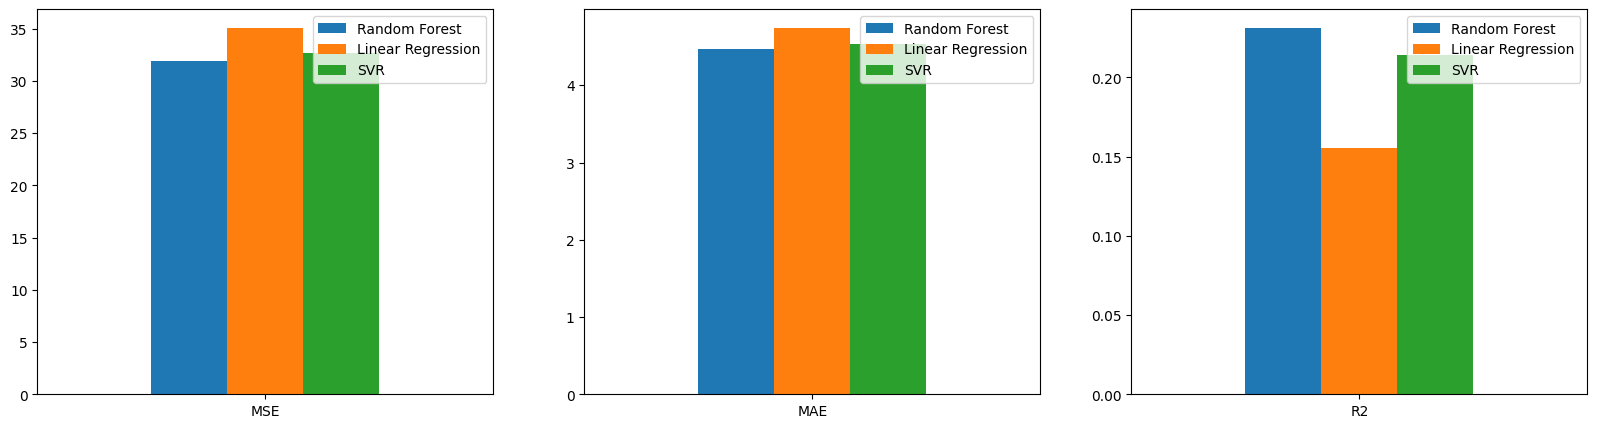

In [ ]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'SVR': SVR_mse}, index = ['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'SVR': SVR_mae}, index = ['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'SVR': SVR_r2}, index = ['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot = 0, ax = axes[0])
df_mae.plot.bar(rot = 0, ax = axes[1])
df_r2.plot.bar(rot = 0, ax = axes[2])

plt.show()

### 4.1 Conclusion from Repeating Example Experiment (Just Random Forest & Linear Regression)

Repeat the experiment in Lab5 - Regression and Dimensionality Reduction.ipynb with insurance.csv and draw conclusions from the results you observe in a markdown cell:

* The Random Forest model outperforms the Linear Regression model in all three criteria, indicating a better fit for this dataset.
* The results suggest that the data relationships are non-linear and may entail complex interactions, which the Random Forest model can better represent than Linear Regression.
* The low R² values for both models suggest potential for improvement. This could be addressed through more feature engineering, hyperparameter adjustment, or testing other modelling methodologies.

### 4.2 Comparing SVR to Random Forest & Linear Regression

Add a third regression algorithm of your choice. Describe how it compares to Random Forest and Linear regression in a markdown cell:

* The MSE values for the SVR and Random Forest models are quite close and low, showing that both models make modest average errors.
* In terms of MAE, SVR and Random Forest are once again quite close, implying that the absolute errors from both models are tiny and similar.
* R² has a slightly higher SVR than Random Forest, indicating a better fit to the data's variance.

These findings indicate that SVR and Random Forest perform similarly on this dataset in terms of prediction accuracy and variance explanation, while both significantly exceed Linear Regression. It's worth noting that SVR, with its similar performance to Random Forest, can be useful in situations where model interpretability or computational performance are important, because SVR models can sometimes be more efficient to train and easier to understand than ensemble methods like Random Forest.


## 6. Two New Dimensionality-Reduction Methods

Add two dimensionality reduction techniques that are sufficiently different from the ones used in the example notebook. Draw conclusions from the results you observe in a markdown cell

### 6.1 Independent Component Analysis (ICA)

In [ ]:
# Define the Independent Component Analysis (ICA) pipeline
pipe_ica = Pipeline([
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', FastICA(n_components = 7)),
    ('regressor', RandomForestRegressor(n_estimators = 10)) # RandomForestRegressor(n_estimators = 10)
])

pipe_ica.fit(X_train, y_train)
predictions_ica = pipe_ica.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [ ]:
RFICA_mse, RFICA_mae, RFICA_r2 = evaluate_model(X_test, y_test, pipe_ica) # RF_best_model

### 6.2 Feature Agglomeration

In [ ]:
# Define the Feature Agglomeration pipeline
pipe_fa = Pipeline([
    ('preprocess', preprocess_pipeline),
    ('reduce_dim', FeatureAgglomeration(n_clusters = 7)),
    ('regressor', RandomForestRegressor(n_estimators = 10))
])

pipe_fa.fit(X_train, y_train)
predictions_fa = pipe_fa.predict(X_test)

In [ ]:
RFFA_mse, RFFA_mae, RFFA_r2 = evaluate_model(X_test, y_test, pipe_fa) # RF_best_model

### 6.3 Comparing & Conclusion

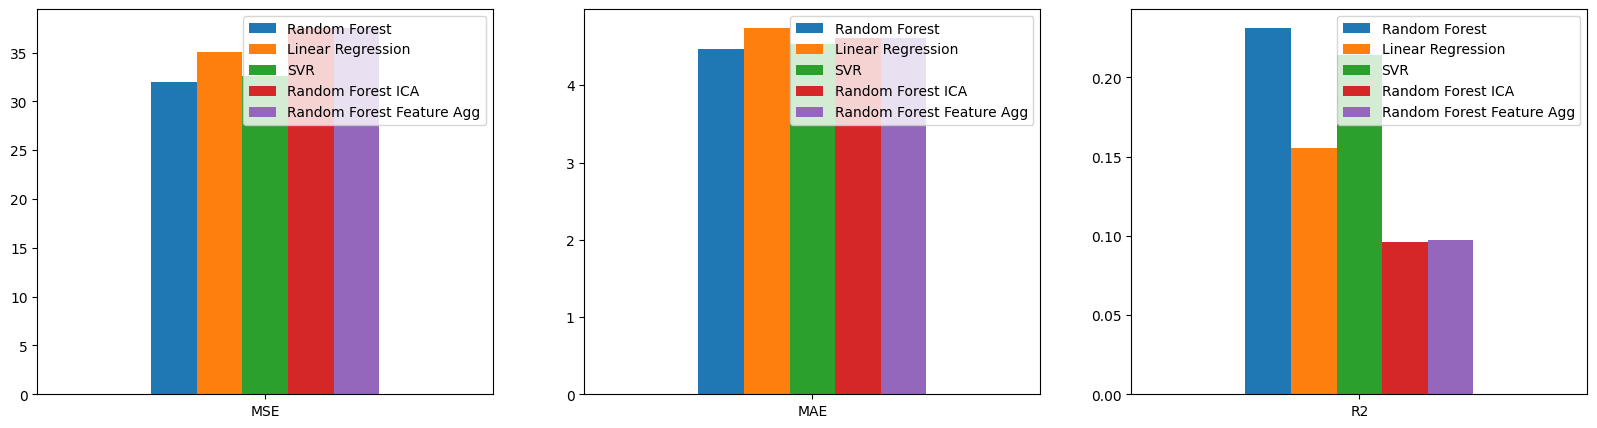

In [ ]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'SVR': SVR_mse, 'Random Forest ICA': RFICA_mse, 'Random Forest Feature Agg': RFFA_mse}, index = ['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'SVR': SVR_mae, 'Random Forest ICA': RFICA_mae, 'Random Forest Feature Agg': RFFA_mae}, index = ['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'SVR': SVR_r2, 'Random Forest ICA': RFICA_r2, 'Random Forest Feature Agg': RFFA_r2}, index = ['R2'])

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 5))

df_mse.plot.bar(rot = 0, ax = axes[0])
df_mae.plot.bar(rot = 0, ax = axes[1])
df_r2.plot.bar(rot = 0, ax = axes[2])

plt.show()

**Mean Squared Error (MSE):**
* This metric represents the average squared difference between the estimated values and the actual value.
* Lower values are better.
* The Random Forest Feature Agg model has the lowest MSE, suggesting that, on average, it makes smaller errors in its predictions than the other models.
* The Random Forest model has the highest MSE, indicating it may be the least accurate model in terms of this metric.

**Mean Absolute Error (MAE):**
* This metric represents the average absolute difference between the estimated values and the actual value.
* Lower values are better here as well.
* Similar to the MSE, the Random Forest Feature Agg model performs the best with the lowest MAE.
* The Random Forest model also has the highest MAE, confirming that its predictions are less accurate on average.

**R squared (R²):**
* The R² metric represents the proportion of the variance for the dependent variable that's explained by the independent variables in the model.
* Higher values (closer to 1) are better, indicating a model that explains more of the variance observed in the data.
* The Random Forest Feature Agg model again performs the best with the highest R² value, meaning it explains the variance in the dataset better than the other models.
* The Random Forest model, on the other hand, has the lowest R² value, indicating it is the least effective at explaining the variance in the dataset.

In summary, based on these metrics, the Random Forest Feature Agg model appears to be the most accurate and effective model for this particular dataset, while the Random Forest model appears to be the least effective. The Linear Regression and SVR (Support Vector Regression) models are generally in the middle but tend to be closer to the Random Forest Feature Agg in performance according to these metrics.

## 7. Train a Final Model

Finally, we can train a Random Forest regression model with all the data we have, assuming that the more data we have the better the model.

In [ ]:
# Function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key, value in dict.items() if prefix in key}
    return {key.replace(prefix, ''):value for key, value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline,
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators = 10, **transform(RF_best_params, 'regresson__')))

final_model = pipe.fit(X, y)

In [ ]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))